# 02. Coarse Grained Simulations

Coarse-graining a box of 500 methanol molecules from the all atom simulation given in `CG_tutorial/meth.gsd` file.

In [38]:
import tensorflow as tf
from tensorflow.keras import layers
import hoomd
import hoomd.md
import hoomd.htf as htf
import numpy as np
import gsd, gsd.hoomd, pickle
import matplotlib.pyplot as plt,matplotlib

In [39]:
%matplotlib inline

In [40]:
### Graph building code ###

def make_train_graph(NN, rcut, NN_aa, N_hidden, system):

    #mamximum number of neighbors=0, graph will not compute forces to use in TF
    graph = htf.graph_builder(0, output_forces=False)
    assign_ops = []
    prints = []
    #get mapping from molecule index to particle index
    molecule_mapping = htf.find_molecules(system)

    for m in molecule_mapping:
        #ensure all molecules are of the same length
        assert len(m) == len(molecule_mapping[0])
    N = sum([len(m) for m in molecule_mapping])
    M = len(molecule_mapping)
    #number of atoms in a molecule=MN
    MN = len(molecule_mapping[0])
    # create one bead mapping. mapping matrices must be created for other types of mappings
    molecule_mapping_matrix = np.ones([1, MN], dtype=np.int)
    #create a mass-weighted M x N mapping operator 
    cg_mapping = htf.sparse_mapping([molecule_mapping_matrix for _ in molecule_mapping], 
                                    molecule_mapping, system=system)
    assert cg_mapping.shape == (M, N)
    #calculate the center of mass of a CG bead
    mapped_pos = htf.center_of_mass(graph.positions[:,:3], cg_mapping, system, name='com-mapped-positions')
    #create the mapped neighbot list
    mapped_nlist = htf.compute_nlist(mapped_pos, rcut, NN, system, False)
    #create a non mass-weighted M x N mapping operator
    force_cg_mapping = htf.sparse_mapping([molecule_mapping_matrix for _ in molecule_mapping], molecule_mapping)
    #calculate the coarse grained forces
    mapped_force = tf.sparse.matmul(force_cg_mapping, graph.forces, name='mapped-forces')
    rdf = graph.compute_rdf([0.1,rcut], 'rdf', nbins=200, nlist=mapped_nlist)
    graph.running_mean(rdf,'avg-rdf') 
    #save the graph
    graph.save('CG_tutorial/cg_model')
    #graph.save('CG_tutorial/cg_model',out_nodes=[ann_optimizer, prints[-1], *assign_ops])                   

In [41]:
### Hoomd-Sim code ###

g = gsd.hoomd.open('CG_tutorial/meth.gsd')
c = hoomd.context.initialize('--mode=cpu')
system = hoomd.init.read_gsd(filename='CG_tutorial/meth.gsd')
c.sorter.disable()
set_rcut=10.0

#call the graph building code
make_train_graph(128,10.0,816,48, system)

with htf.tfcompute('CG_tutorial/cg_model', device='CPU:0') as tfcompute:
    nlist = hoomd.md.nlist.cell()

    #set-up pppm
    charged = hoomd.group.all();
    pppm = hoomd.md.charge.pppm(nlist=nlist, group=charged)
    pppm.set_params(Nx=32, Ny=32, Nz=32, order=6, rcut=set_rcut)

    #set-up pair coefficients
    nlist.reset_exclusions(['1-2', '1-3', '1-4','body'])
    lj = hoomd.md.pair.force_shifted_lj(r_cut=set_rcut, nlist=nlist)
    forces = [lj]
    lj.pair_coeff.set("opls_156", "opls_156", sigma=2.5, epsilon=0.03)
    lj.pair_coeff.set("opls_156", "opls_157", sigma=2.96, epsilon=0.05)
    lj.pair_coeff.set("opls_156", "opls_154", sigma=2.79, epsilon=0.07)
    lj.pair_coeff.set("opls_156", "opls_155", sigma=5.0, epsilon=0.0)
    lj.pair_coeff.set("opls_157", "opls_157", sigma=3.5, epsilon=0.07)
    lj.pair_coeff.set("opls_157", "opls_154", sigma=3.31, epsilon=0.11)
    lj.pair_coeff.set("opls_157", "opls_155", sigma=5.92, epsilon=0.0)
    lj.pair_coeff.set("opls_154", "opls_154", sigma=3.12, epsilon=0.17)
    lj.pair_coeff.set("opls_154", "opls_155", sigma=5.59, epsilon=0.0)
    lj.pair_coeff.set("opls_155", "opls_155", sigma=10.0, epsilon=0.0)

    #set-up bonds
    harmonic = hoomd.md.bond.harmonic()
    harmonic.bond_coeff.set("opls_156-opls_157", k=340.00, r0=1.09)
    harmonic.bond_coeff.set("opls_154-opls_157", k=320.00, r0=1.41)
    harmonic.bond_coeff.set("opls_154-opls_155", k=553.00, r0=0.95)

    #set-up angles
    harm_angle = hoomd.md.angle.harmonic()
    harm_angle.angle_coeff.set("opls_154-opls_157-opls_156", k=70.0, t0=1.90)
    harm_angle.angle_coeff.set("opls_155-opls_154-opls_157", k=110.0, t0=1.89)
    harm_angle.angle_coeff.set("opls_156-opls_157-opls_156", k=66.0, t0=1.88)

    #set-up dihedrals
    dihedral = hoomd.md.dihedral.opls()
    dihedral.dihedral_coeff.set("opls_155-opls_154-opls_157-opls_156", k1=0.0, k2=0.0, k3=0.45, k4=0.0)

    group_all = hoomd.group.all()
    kT = 1.9872/1000

    #NVT Simulation in Hoomd
    im = hoomd.md.integrate.mode_standard(dt=5.0/489.0)
    nvt = hoomd.md.integrate.nvt(group=group_all, kT=298.15 * kT, tau=350 / 48.9)
    nvt.randomize_velocities(1234)

    #equilibrate
    hoomd.run(200)

    #communicate positions, neighbor list and forces to TensorFlow model
    tfcompute.attach(nlist, r_cut=set_rcut,period=1)

    #Hoomd production run
    hoomd.run(500)

print('Training Done')

notice(2): Group "all" created containing 6000 particles
Finding molecules...99.90%
Note: Backed-up CG_tutorial/cg_model previous model to CG_tutorial/cg_model/previous_model_0
notice(2): Started TF Session Manager.
-----
You are using PPPM. Please cite the following:
* D N LeBard, B G Levine, S A Barr, A Jusufi, S Sanders, M L Klein, and A Z
  Panagiotopoulos. "Self-assembly of coarse-grained ionic surfactants
  accelerated by graphics processing units", Journal of Computational Physics 8
  (2012) 2385-2397
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 5 exclusions             : 6000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **


*Warning*: charge.pppm: system is not neutral and unscreened interactions are calculated, the net charge is -0.000357628


notice(2): charge.pppm: RMS error: 0.000406376
Time 00:00:14 | Step 23 / 200 | TPS 2.19928 | ETA 00:01:20
Time 00:00:24 | Step 47 / 200 | TPS 2.29609 | ETA 00:01:06
Time 00:00:34 | Step 70 / 200 | TPS 2.27509 | ETA 00:00:57
Time 00:00:44 | Step 93 / 200 | TPS 2.27565 | ETA 00:00:47
Time 00:00:55 | Step 117 / 200 | TPS 2.3679 | ETA 00:00:35
Time 00:01:05 | Step 141 / 200 | TPS 2.37067 | ETA 00:00:24
Time 00:01:15 | Step 164 / 200 | TPS 2.2804 | ETA 00:00:15
Time 00:01:25 | Step 188 / 200 | TPS 2.37285 | ETA 00:00:05
Time 00:01:30 | Step 200 / 200 | TPS 2.3716 | ETA 00:00:00
Average TPS: 2.3082
---------
-- Neighborlist stats:
52 normal updates / 0 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 533 / n_neigh_avg: 211.555
shortest rebuild period: 3
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 168 / n_max: 294 / n_avg: 222.222
** run complete **
notice(2): Force mode is FORCE_MODE.hoomd2tf 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
INFO

INFO:tensorflow:Restoring parameters from CG_tutorial/cg_model/model-499


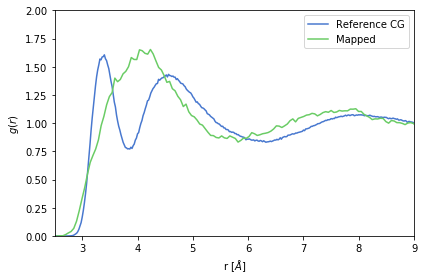

In [42]:
## Plot RDFs between Mapped CG beads (center of masses) and the reference (C-O in all atom system )

train_vars = htf.load_variables('CG_tutorial/cg_model', ['avg-rdf', 'rdf-r'])

matplotlib.style.use('seaborn-muted')
ref_rdf = np.loadtxt('CG_tutorial/ref_rdf.xvg',comments=('#','@'))
plt.plot(ref_rdf[:,0]*10,ref_rdf[:,1],label ='Reference CG')
plt.plot(train_vars['rdf-r'], train_vars['avg-rdf'] / train_vars['avg-rdf'][-1], label='Mapped')
plt.xlim(2.5,9)
plt.ylim(0,2)
plt.xlabel(r'r [$\AA$]')
plt.ylabel('$g(r)$')
plt.tight_layout()
plt.legend()